In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

from datetime import datetime

%matplotlib inline

In [2]:
import findspark
findspark.init()
import pyspark

from pyspark.sql.types import DateType
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import *
import pyspark.sql.functions as fn
from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

<h1>Data Collection</h1>

Amazon Data : Collection/Analysis of data from Amazon (Reviews and Metadata of products) associated to the thema : ecology, bio, renewable etc... (see keywords vector)

__Review data__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'reviews' file for a 
chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)

Features:

- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

__Metadata (Product)__ : 
Download http://jmcauley.ucsd.edu/data/amazon/links.html go to 'Per Category Files' section and DL 'metadata' file for a chosen category. (Or the Complete Review Data 18GB) It is better to not take the 5-core data as it contains only 5 reviews for each products (we're missing data)


Features:

- asin - ID of the product, e.g. 0000031852
- title - name of the product
- price - price in US dollars (at time of crawl)
- imUrl - url of the product image
- related - related products (also bought, also viewed, bought together, buy after viewing)
- salesRank - sales rank information
- brand - brand name
- categories - list of categories the product belongs to



<h3> TO DO LIST </h3>

In the followings statements, 'extracted' means filtered with the thema : products/reviews associated to bio/ecology/renewable etc...

- Choose category to focus on : Books ? / Health Care ....
- Show Proportion of extracted data compared to the full data (of the category)
- Comparison of extracted data between categories (which one contains the most related products/review interest)
- Distribution Price of extracted data (per category) --> Compare between category and with not extracted data in the same category
- Distribution salesRank of extracted data (best per category, mean, proportion of 10% first, 20%first etc...) --> Compare between category and with not extracted data in the same category

- __Keywords__ : How to efficiently implement the selection of related data ? Currently with a list of key words, can use regexp, better writing of keywords etc.. ?

- Associate Metadata with Reviews : __Join__
> - Extract year of 1st review (which will give the publication year of the product -approximately-)
> - Histograms number of extracted products per year 
> - Histograms number of extracted reviews per year
> - Nb of reviews per product per category --> Distribution, compare between categories and with not extracted data to see if reviewers are more inerested/active with our thema products compared to others
> - Helplful note : Compare between categories / Overall
> - Mean rating product : Compare with other products


- __Prediction__
> - Nb of products for following years (Linear Regression)
> - Sentiment Analysis on Reviews (Experiment ?)
> - Prediction overall on price for following years ? (LR)


Create a folder named 'data' and store the downloaded json zip file. Then unzip in there to get the json file.

In [3]:
DATA_DIR = 'data/'

In [4]:
keywords = [" global warming", " solar energy", " recycling ", " pollution ", "solar power", " endangered species", "air pollution", \
" water pollution", " wind energy", " climate change", " wind power", " recycle ", " deforestation", " greenhouse effect", "environment", \
" sustainability ", " natural resources", "alternative energy", " climate ", "global warming", "renewable energy", " ecology", "composting", \
" carbon footprint", " bio ", " biosphere ", " renewable "]

Need to load once the global json. You probably won't be able to store it in parquet directly because some features ('related' or 'categories' e.g) can't be written in a file as it is a specific array with weird names. 
You then to clean first the data and store it to parquet. If you want next to retrieve some deleted features ('related' for example) you better do the filtering and extraction on the cleaned dataset and then merge or filter the global dataset using the new one.

> __SAMPLE WITH THE CATEGORY HEALTH AND PERSONAL CARE METADATA__

Download the meta_Health_and_Personal_Care.json file

In [5]:
meta_products = spark.read.json(DATA_DIR+"meta_Books.json")

In [6]:
# To see an example of the data
meta_products.take(1)

[Row(_corrupt_record=None, asin='0001048791', brand=None, categories=[['Books']], description=None, imUrl='http://ecx.images-amazon.com/images/I/51MKP0T4DBL.jpg', price=None, related=None, salesRank=Row(Arts, Crafts & Sewing=None, Books=6334800, Cell Phones & Accessories=None, Clothing=None, Electronics=None, Health & Personal Care=None, Home &amp; Kitchen=None, Industrial & Scientific=None, Jewelry=None, Kitchen & Dining=None, Movies & TV=None, Music=None, Musical Instruments=None, Office Products=None, Shoes=None, Sports &amp; Outdoors=None, Toys & Games=None), title='The Crucible: Performed by Stuart Pankin, Jerome Dempsey &amp; Cast')]

These are the IDs for each feature in order to extract them in some filtering/flatmap functions with spark

Example: lambda r: r[0], r[1] etc...

- _corrupt_record 0
- asin 1
- brand 2
- categories 3
- description 4
- imUrl 5
- price 6 
- related 7 
- salesRank 8
- title 9

> The next code will extract the relevant and writtable features. It will then store it into parquet 

In [7]:
# This will extract only the features and turn them into more readable features.
# Filter salesRank = None because this will lead to problems for the writing in parquet
# Features removed : corruptRecord, imURL, related
data_cleaned = meta_products.rdd.flatMap(lambda r: [(r[1], r[2], 'Books', r[4], r[6],  r[9] )]) 


#

In [8]:
# Define the StructType to define the DataFrame that we'll create with the previously extracted rdd table

schema = StructType([
    StructField("asin", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("category", StringType(), True),
    StructField("description", StringType(), True),
    StructField("price", FloatType(), True),
    #StructField("salesRank", IntegerType(), True),
    StructField("title", StringType(), True)
])

In [9]:
# Transform the RDD data into DataFrame (we'll then be able to store it in Parquet)
datacleaned_DF = spark.createDataFrame(data_cleaned, schema=schema)

In [10]:
# Example of the cleaned data (and association with the created StrucType schema)
datacleaned_DF.show(3)

+----------+-----+--------+--------------------+-----+--------------------+
|      asin|brand|category|         description|price|               title|
+----------+-----+--------+--------------------+-----+--------------------+
|0001048791| null|   Books|                null| null|The Crucible: Per...|
|0001048775| null|   Books|William Shakespea...| null|Measure for Measu...|
|0001048236| null|   Books|&#34;One thing is...| 9.26|The Sherlock Holm...|
+----------+-----+--------+--------------------+-----+--------------------+
only showing top 3 rows



In [11]:
#Save into parquet to save time in the next times
datacleaned_DF.write.mode('overwrite').parquet("meta_Books.parquet")

In [12]:
# Read from the parquet data
datacleaned_DF = spark.read.parquet("meta_Books.parquet")

In [13]:
# Example to see the structure of data (The StrucType schema is indeed there)
datacleaned_DF.take(1)

[Row(asin='1453610596', brand=None, category='Books', description=None, price=1.9900000095367432, title='The Complete Works of Ralph Waldo Emerson &amp; Henry David Thoreau')]

Now that we created the new dataset here are the features ID of this new one.

These are the IDs for each feature in order to extract them in some filtering/flatmap functions with spark
Example: lambda r: r[0], r[1] etc...

- asin 0
- brand 1
- category 2
- description 3
- price 4 
- title 5

In [14]:
print("Number of data samples : " + str(datacleaned_DF.rdd.count()) )

Number of data samples : 2370585


> We will now extract the data related to our thema : Ecology, Bio, Renewable etc...

In [15]:
# Filter with title and description not equal to None
# We will then be able to test if those features contains words defined in the keyword vector 
# The keyword vector represents the thema that we want : ecology, bio etc...
filter_products_bio = datacleaned_DF.rdd.filter(lambda r: (r[5] != None) &  (r[3] != None)) \
                    .filter(lambda r: (any(word in r[5].lower() for word in keywords)) | (any(word in r[3].lower() for word in keywords)) ) 



In [16]:
print("Number of data samples related to ecology/bio/renewable etc... : " + str(filter_products_bio.count()) )

Number of data samples related to ecology/bio/renewable etc... : 20723


In [17]:
filter_products_bio.take(3)

[Row(asin='1453618805', brand=None, category='Books', description="Edmund Kealoha Parker Sr. was born on March 19, 1931, in Honolulu, Hawaii.  Growing up in the harsh Honolulu environment, young Ed had many opportunities to defend himself, his principles, and his honor. Ed attended Kamehameha High School, he excelled in sports, becoming an accomplished athlete. He became a judo black belt by the age of fifteen, as well as an amateur boxing champion. He competed in track and field, and became a member of the Junior Varsity Football Team.  Ed was born and raised in a devout Mormon household. He graduated from Kamehameha High School served his country in the Coast Guard for three years. He worked hard to achieve his Black Belt Certificate from Professor William K. S. Chow June 5, 1953. During his high school and young adult years he dated Marguerite Leilani Bertelmann Yap. He graduated from Brigham Young University and married Marguerite Leilani Bertelmann Yap in December 28, 1954 in the 

In [18]:
schema = StructType([
    StructField("asin", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("category", StringType(), True),
    StructField("description", StringType(), True),
    StructField("price", FloatType(), True),
    #StructField("salesRank", IntegerType(), True),
    StructField("title", StringType(), True)
])

In [19]:
# Transform the RDD data into DataFrame (we'll then be able work and join with review data)
DF_filter_products_bio = spark.createDataFrame(filter_products_bio, schema=schema)

> __SAMPLE WITH THE CATEGORY HEALTH AND PERSONAL CARE REVIEWS__

Download the reviews_Health_and_Personal_Care.json file

In [20]:
reviews = spark.read.json(DATA_DIR+"reviews_Books.json")

In [21]:
# To see an example of the data
reviews.take(1)

[Row(asin='0000000116', helpful=[5, 5], overall=4.0, reviewText="Interesting Grisham tale of a lawyer that takes millions of dollars from his firm after faking his own death. Grisham usually is able to hook his readers early and ,in this case, doesn't play his hand to soon. The usually reliable Frank Mueller makes this story even an even better bet on Audiobook.", reviewTime='04 27, 2002', reviewerID='AH2L9G3DQHHAJ', reviewerName='chris', summary='Show me the money!', unixReviewTime=1019865600)]

These are the IDs for each feature in order to extract them in some filtering/flatmap functions with spark

Example: lambda r: r[0], r[1] etc...

- asin 0
- helpful 1
- overall 2
- reviewText 3
- reviewTime 4
- reviewerID 5
- reviewerName 6 
- summary 7 
- unixReviewTime 8

In [22]:
#Save into parquet to save time in the next times
reviews.write.mode('overwrite').parquet("reviews_Books.parquet")

In [23]:
# Read from the parquet data
reviews = spark.read.parquet("reviews_Books.parquet")

In [24]:
print("Number of reviews : " + str(reviews.rdd.count()) )

Number of reviews : 22507155


__Join Reviews and Metadata__ 

We will now join the metadata and review dataset using the product ID. Then we'll have the reviews for all products concerned. Here we will join with the filtered data containing the products related to the thema 'bio,recycle,ecology' etc... 

Then in each row we will have the product description and the reviews associated

In [25]:
# This way allows no duplicate
review_product_join = DF_filter_products_bio.join(reviews, ['asin'])

In [26]:
print("Number of reviews related to bio/renewable/ecology etc... : " + str(review_product_join.rdd.count()) )

Number of reviews related to bio/renewable/ecology etc... : 207836


In [27]:
# Example of joined data
review_product_join.take(1)

[Row(asin='0061866121', brand=None, category='Books', description="From bestselling author Simon Winchester comes the immense and thrilling story of the world's most mysterious and breathtaking natural wonder: the Atlantic Ocean.Atlanticis a biography of a tremendous space that has been central to the ambitions of explorers, scientists, and warriors, and continues profoundly to affect our character, attitudes, and dreams.  Spanning the ocean's story, from its geological origins to the age of exploration, from World War II battles to today's struggles with pollution and overfishing, Winchester's narrative is epic, intimate, and awe inspiring.Until a thousand years ago, few humans ventured into the Atlantic or imagined traversing its vast infinity. But once the first daring mariners successfully navigated to its far shores&#8212;whether they were Vikings, the Irish, the Basques, John Cabot, or Christopher Columbus in the north, or the Portuguese and the Spanish in the south&#8212;the Atl

In [28]:
review_product_join.write.mode('overwrite').parquet("joined_Books.parquet")

In [29]:
import pyspark.sql.functions as sqlf

In [30]:
firstreview = review_product_join.groupBy("asin").agg(sqlf.min("unixReviewTime"))
#.min('unixReviewTime')

In [31]:
firstreview.take(5)

[Row(asin='0061866121', min(unixReviewTime)=1346112000),
 Row(asin='0062506498', min(unixReviewTime)=1079308800),
 Row(asin='0070152829', min(unixReviewTime)=1245715200),
 Row(asin='0071402594', min(unixReviewTime)=1269129600),
 Row(asin='0071823654', min(unixReviewTime)=1388966400)]

In [32]:
year_reviews_Pandas = firstreview.toPandas()

In [33]:
year_reviews_Pandas.head()

,asin,min(unixReviewTime)
0,0061866121,1346112000
1,0062506498,1079308800
2,0070152829,1245715200
3,0071402594,1269129600
4,0071823654,1388966400


In [34]:
year_reviews_Pandas['Year'] = pd.to_datetime(year_reviews_Pandas['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1102b9ba8>]],
      dtype=object)

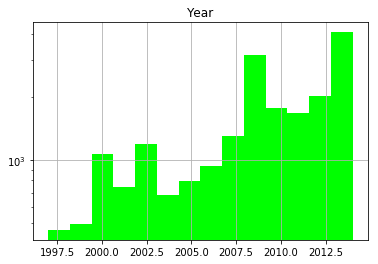

In [35]:
year_reviews_Pandas.hist("Year", color="lime", log=True,bins=14)

Evolution of nb of reviews /year linked to products bio/renwable etc...

In [36]:
globalfirstreview = reviews.groupBy("asin").agg(sqlf.min("unixReviewTime"))

In [37]:
globalfirstreview.take(5)

[Row(asin='0153157356', min(unixReviewTime)=1379980800),
 Row(asin='0153348518', min(unixReviewTime)=1262131200),
 Row(asin='0153375256', min(unixReviewTime)=1284249600),
 Row(asin='0153396245', min(unixReviewTime)=1241395200),
 Row(asin='0153820608', min(unixReviewTime)=1401840000)]

In [38]:
globalyear_reviews_Pandas = globalfirstreview.toPandas()

In [39]:
globalyear_reviews_Pandas['Year'] = pd.to_datetime(globalyear_reviews_Pandas['min(unixReviewTime)'],unit='s').map(lambda x: x.year)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1101dd320>]],
      dtype=object)

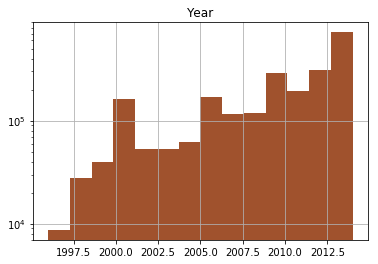

In [40]:
globalyear_reviews_Pandas.hist("Year", log=True, color="sienna", bins = 14)

We can see in the merged dataframe that there is the features from metadata about the products, and the features about the reviews. We will then describe the features ID : 

Example: lambda r: r[0], r[1] etc...

- asin 0
- brand 1
- category 2
- description 3
- price 4
- salesRank 5
- title 6
- helpful 7 
- overall 8
- reviewText 9
- reviewTime 10
- reviewerID 11
- reviewerName 12
- summary 13
- unixReviewTime 14



In [41]:
nbreviews_perproduct=  review_product_join.rdd.map(lambda r: [r[0],1]) \
            .reduceByKey(lambda a,b: a+b)

In [42]:
nbreviews_DF = spark.createDataFrame(nbreviews_perproduct, ['productID','freq'])

In [43]:
nbreviews_Pandas = nbreviews_DF.toPandas()

Text(0.5,1,'Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..')

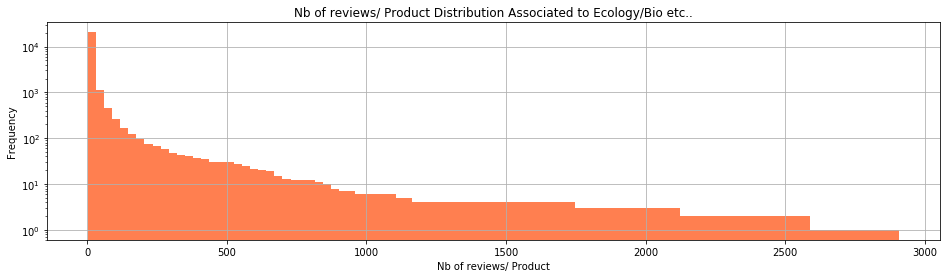

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
fig.set_size_inches(16,4)

nbreviews_Pandas.hist(log=True, bins = 100, color="coral", cumulative=-1,figsize =(16,4), ax=axes)

axes.set_xlabel("Nb of reviews/ Product")
axes.set_ylabel("Frequency")
axes.set_title("Nb of reviews/ Product Distribution Associated to Ecology/Bio etc..")